In [182]:
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from matplotlib.patches import FancyArrowPatch
from scipy.optimize import minimize_scalar
%matplotlib inline
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.axes_size import Fixed, Scaled
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization.wcsaxes import Quadrangle
from matplotlib.patches import Rectangle

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],              # LaTeX default is 10pt font.            # Make the legend/label fonts a little smaller
    "pgf.preamble": r"\usepackage[ut f8x]{inputenc} \usepackage[T1]{fontenc}"   
}
 # use utf8 fonts becasue your computer can handle it :)
     # plots will be generated using this preamble
mpl.rcParams.update(pgf_with_latex)

#mpl.rcParams.keys() 

In [183]:
path='/Users/kirstytaggart/trilogy/2021sjt/'
img='2021sjt_RGB.fits'
wcs_img='hst_16691_27_wfc3_uvis_f555w_ierg27_drc.fits'
img_hst = get_pkg_data_filename(path+img)
img_wcs = get_pkg_data_filename(path+wcs_img)
fits.info(img_hst), fits.info(img_wcs)

Filename: /Users/kirstytaggart/trilogy/2021sjt/2021sjt_RGB.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 ImageHDU         7   (5564, 5695)   uint8   
  2                1 ImageHDU         7   (5564, 5695)   uint8   
  3                1 ImageHDU         7   (5564, 5695)   uint8   
Filename: /Users/kirstytaggart/trilogy/2021sjt/hst_16691_27_wfc3_uvis_f555w_ierg27_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     887   ()      
  1  SCI           1 ImageHDU        92   (5564, 5695)   float32   
  2  WHT           1 ImageHDU        45   (5564, 5695)   float32   
  3  CTX           1 ImageHDU        40   (5564, 5695)   int32   
  4  HDRTAB        1 BinTableHDU    564   4R x 277C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 4A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, 8A, 23A, D, D, D, D, K, K, 8A, 23A

(None, None)

In [184]:
hdu_img1 = fits.open(img_hst)[1]
hdu_img2 = fits.open(img_hst)[2]
hdu_img3 = fits.open(img_hst)[3]

data1=hdu_img1.data
data2=hdu_img2.data
data3=hdu_img3.data

hdu_wcs = fits.open(img_wcs)[1]

In [185]:
wcs = WCS(hdu_wcs.header)
stack=np.dstack((data1,data2,data3))

In [186]:

def compass(self, x, y, size, color,fontsize):
        """Add a compass to indicate the north and east directions.

        Parameters
        ----------
        x, y : float
            Position of compass vertex in axes coordinates.
        size : float
            Size of compass in axes coordinates.
        fontsize: float
            Size of the N and S labels
        color: string 
            color of the scale bar, and the font

        """
        xy = x, y
        scale = self.wcs.pixel_scale_matrix
        scale /= np.sqrt(np.abs(np.linalg.det(scale)))
        return [self.annotate(label, xy, xy + size * n, self.transAxes, self.transAxes, color=color,ha='center', va='center',fontsize=fontsize,arrowprops=dict(color=color,arrowstyle='<-', shrinkA=0.0, shrinkB=0.0))
                for n, label, ha, va in zip(scale, 'EN',['right', 'center'],['center', 'bottom'])]

class ScaleBar(FancyArrowPatch):

    def _func(self, dx, x, y):
        p1, p2 = self._transAxesToWorld.transform([[x, y], [x + dx, y]])
        p1 = SkyCoord(*p1, unit=u.deg)
        p2 = SkyCoord(*p2, unit=u.deg)
        return np.square((p1.separation(p2) - self._length).value)

    def __init__(self, ax, xy, length, color, *args, **kwargs):
        x, y = xy
        self._ax = ax
        self._length = u.Quantity(length)
        self._transAxesToWorld = (
            (ax.transAxes - ax.transData) + ax.coords.frame.transform)
        dx = minimize_scalar(self._func, args=xy, bounds=[0, 1 - x], method='bounded').x
        custom_kwargs = kwargs
        kwargs = dict(
            capstyle='round',
            color=color,
            linewidth=mpl.rcParams['lines.linewidth'],
        )
        kwargs.update(custom_kwargs)
        super().__init__(
            xy, (x + dx, y),
            *args,
            arrowstyle='-',
            shrinkA=0.0,
            shrinkB=0.0,
            transform=ax.transAxes,
            **kwargs)

    def label(self,color,fontsize,**kwargs):
        (x0, y), (x1, _) = self._posA_posB
        #print(self._length)
        if self._length.unit=='arcsec':
         s = "{0.value:g}$''$".format(self._length)
        else:
         s = "{0.value:g}{0.unit:unicode}".format(self._length)
        print(s)
        return self._ax.text(
            0.5 * (x0 + x1), y, s,
            ha='center', va='bottom',color=color,fontsize=fontsize, transform=self._ax.transAxes, **kwargs)    
    
    
    
def scalebar(self, *args, **kwargs):
        """Add scale bar.

        Parameters
        ----------
        xy : tuple
            The axes coordinates of the scale bar.
        length : `astropy.units.Quantity`
            The length of the scale bar in angle-compatible units.

        Other parameters
        ----------------
        args :
            Extra arguments for `matplotlib.patches.FancyArrowPatch`
        kwargs :
            Extra keyword arguments for `matplotlib.patches.FancyArrowPatch`

        Returns
        -------
        patch : `matplotlib.patches.FancyArrowPatch`

        """
        return self.add_patch(ScaleBar(self, *args, **kwargs))
    
def crosshair(self, ra, dec, size, color,linewidth):
        """Add a cross hair at supernova postion."""
        sf=0.5
        gapsize=10
        
        ch1 = Quadrangle((ra,dec)*u.deg+(gapsize,0)*u.arcsec, size* u.arcsec,0* u.arcsec,lw=linewidth,
               edgecolor=color, facecolor='none',
               transform=ax1.get_transform('fk5'))
        ch2 = Quadrangle((ra,dec)*u.deg, 0* u.arcsec,sf*size* u.arcsec,lw=linewidth,
               edgecolor=color, facecolor='none',
               transform=ax1.get_transform('fk5'))
        return self.add_patch(ch1),self.add_patch(ch2)



20$''$


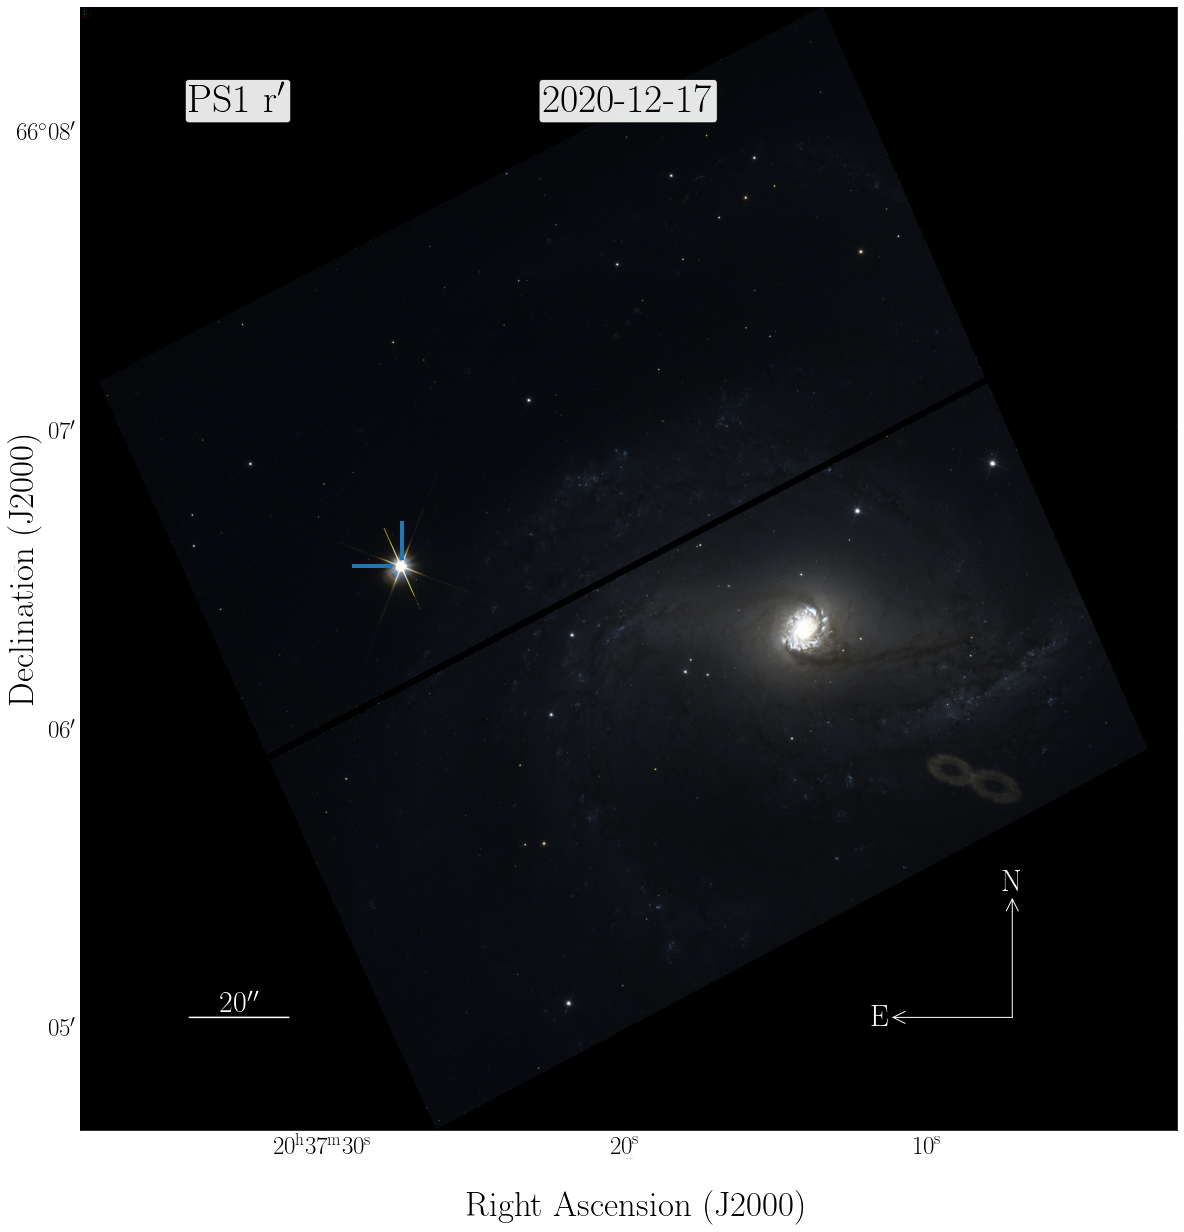

In [202]:
fig = plt.figure(figsize=(25,12),facecolor='white')
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0],projection=wcs)

norm = ImageNormalize(stretch=SqrtStretch())

ax1.imshow(stack)

sn_pos=(309.3645044,66.1090157)*u.deg

r = SphericalCircle(sn_pos, 20* u.arcsec,lw=5,
                     edgecolor='yellow', facecolor='none',
                     transform=ax1.get_transform('fk5'))
#ax1.add_patch(r)

# add crosshair
ch_lenth,ch_width,ch_gap=200,20,40                    
x, y = wcs.world_to_pixel(SkyCoord(sn_pos[0],sn_pos[1], frame='fk5'))
ax1.add_patch(Rectangle((x-ch_gap, y), -ch_lenth, ch_width))
ax1.add_patch(Rectangle((x, y+ch_gap), ch_width, ch_lenth))
                         
compass(ax1,0.85,0.1,0.12,'white',30)
scalebar(ax1,(0.1, 0.1),20 * u.arcsec,'white').label('white',30)

norm = ImageNormalize(stretch=SqrtStretch())

ax1.set_xticklabels([])
ax1.set_ylabel('',fontsize=0)
ax1.set_xlabel('',fontsize=0)
ax1.tick_params(axis='both',labelsize=25)
ax1.tick_params(direction="in")

plt.subplots_adjust(wspace=0.24)
plt.subplots_adjust(hspace=-0.1)
plt.subplots_adjust(left=0.04)
plt.subplots_adjust(right=0.85)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=-0.3)

ax1.text(0.5, 0.9, r'2020-12-17',transform=ax1.transAxes,verticalalignment='bottom',\
         horizontalalignment='center',color='black', fontsize=40,fontname='font.serif  : cm',\
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1',alpha=0.9))
ax1.text(0.1, 0.9, r'PS1 r$^\prime$',transform=ax1.transAxes,verticalalignment='bottom',\
         horizontalalignment='left',color='black', fontsize=40,fontname='font.serif  : cm',\
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1',alpha=0.9))

fig.text(0.45, -0.4, 'Right Ascension (J2000)', ha='center',fontsize=35)
fig.text(0.1, 0.35, 'Declination (J2000)', va='center', rotation='vertical',fontsize=35)


plt.savefig('2021sjt_rgb.png',dpi=300,bbox_inches='tight',transparent=False)